# Predicciones Avanzadas en Béisbol

En este notebook, queremos un análisis un poco más ambicioso. En lugar de solo predecir el resultado de un lanzamiento aislado, utilizaremos el **contexto** y la **secuencia** del juego para realizar predicciones más complejas.

## Objetivos:
1.  **Ingeniería de Características Avanzada**: Crear variables de "rezago" (lag features) para capturar la secuencia de lanzamientos.
2.  **Predicción del Próximo Lanzamiento**: ¿Qué lanzará el pitcher ahora? (Recta, Curva, Slider...)
3.  **Probabilidad de Swing**: ¿Hará swing el bateador ante este lanzamiento?
4.  **Expected Batting Average (xBA)**: Predicción de la calidad del contacto basada en la física del batazo.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

%matplotlib inline

## 1. Carga de Datos y Selección de Variables

Vamos a cargar nuevamente los datos crudos para tener acceso a todas las columnas necesarias, incluyendo las de física del batazo (`launch_speed`, `launch_angle`) y contexto del juego.

In [29]:
cols_to_load = [
    # Identificadores y Orden
    'game_pk', 'at_bat_number', 'pitch_number', 'player_name', 'batter', 'pitcher',
    # Lanzamiento
    'pitch_type', 'release_speed', 'zone', 'pfx_x', 'pfx_z', 'stand', 'p_throws', 'plate_x', 'plate_z',
    # Contexto del Juego
    'balls', 'strikes', 'outs_when_up', 'inning', 'home_score', 'away_score',
    'on_1b', 'on_2b', 'on_3b',
    # Resultados
    'description', 'events', 'type',
    # Física del Batazo (para xBA)
    'launch_speed', 'launch_angle', 'woba_value', 'estimated_ba_using_speedangle'
]

try:
    df_2023 = pd.read_csv('../data/statcast_raw_data/statcast_2023.csv', usecols=cols_to_load)
    df_2024 = pd.read_csv('../data/statcast_raw_data/statcast_2024.csv', usecols=cols_to_load)
    df = pd.concat([df_2023, df_2024], axis=0)
    print(f"Datos cargados: {df.shape}")
except FileNotFoundError:
    print("Error: No se encontraron los archivos de datos crudos en '../data/statcast_raw_data/'.")

Datos cargados: (1534286, 31)


## 2.Feature Engineering

Aquí vamos a crear variables que le den al modelo "memoria" y contexto. En otras palabras, le vamos a dar al modelo la información relevante para que pueda predecir el resultado del lanzamiento.

In [30]:
# Ordenar para asegurar la secuencia correcta
df = df.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])

# 2.1 Variables de Contexto
# Diferencia de carreras (desde la perspectiva del pitcher/defensa, o absoluto)
df['score_diff'] = df['home_score'] - df['away_score']

# Estado de las bases (Categórica)
df['on_1b'] = df['on_1b'].notna().astype(int)
df['on_2b'] = df['on_2b'].notna().astype(int)
df['on_3b'] = df['on_3b'].notna().astype(int)
df['bases_state'] = df['on_1b'].astype(str) + df['on_2b'].astype(str) + df['on_3b'].astype(str)

# 2.2 Variables de Rezago (Lag Features)
# Queremos saber qué pasó en el lanzamiento ANTERIOR dentro del mismo turno al bate.
df['prev_pitch_type'] = df.groupby(['game_pk', 'at_bat_number'])['pitch_type'].shift(1)
df['prev_description'] = df.groupby(['game_pk', 'at_bat_number'])['description'].shift(1)
df['prev_speed'] = df.groupby(['game_pk', 'at_bat_number'])['release_speed'].shift(1)

# Llenar nulos en lags (el primer lanzamiento no tiene previo)
df['prev_pitch_type'] = df['prev_pitch_type'].fillna('None')
df['prev_description'] = df['prev_description'].fillna('None')
df['prev_speed'] = df['prev_speed'].fillna(0)

print("Nuevas variables creadas.")
df[['pitch_type', 'prev_pitch_type', 'description', 'prev_description']].head(10)

Nuevas variables creadas.


,pitch_type,prev_pitch_type,description,prev_description
16279,FF,None,called_strike,None
16278,SI,FF,foul,called_strike
16277,FF,SI,foul,foul
16276,FC,FF,foul,foul
16275,SI,FC,ball,foul
16274,FC,SI,ball,ball
16273,SL,FC,foul,ball
16272,SI,SL,ball,foul
16271,SI,SI,foul,ball
16270,FC,SI,hit_into_play,foul


## 2.3 Tendencias del Pitcher 

Para mejorar la predicción, vamos a calcular la probabilidad histórica de que cada pitcher lance cada tipo de lanzamiento. Esto le da al modelo información sobre el "repertorio" y las preferencias de cada lanzador.

In [31]:
# Calcular la distribución de lanzamientos por pitcher
pitcher_tendencies = df.groupby(['pitcher', 'pitch_type']).size().unstack(fill_value=0)
pitcher_tendencies = pitcher_tendencies.div(pitcher_tendencies.sum(axis=1), axis=0)

# Renombrar columnas para evitar colisiones
pitcher_tendencies.columns = [f'pitcher_prob_{col}' for col in pitcher_tendencies.columns]
pitcher_tendencies.reset_index(inplace=True)

# Unir con el DataFrame principal
df = df.merge(pitcher_tendencies, on='pitcher', how='left')

# Llenar NaNs con 0 (para pitchers nuevos o sin datos suficientes)
prob_cols = [col for col in df.columns if col.startswith('pitcher_prob_')]
df[prob_cols] = df[prob_cols].fillna(0)

print(f"Tendencias calculadas. Nuevas columnas: {len(prob_cols)}")
df[['player_name'] + prob_cols[:5]].head()

Tendencias calculadas. Nuevas columnas: 17


,player_name,pitcher_prob_CH,pitcher_prob_CS,pitcher_prob_CU,pitcher_prob_EP,pitcher_prob_FA
0,"Greinke, Zack",0.164107,0.000439,0.139974,0.0,0.0
1,"Greinke, Zack",0.164107,0.000439,0.139974,0.0,0.0
2,"Greinke, Zack",0.164107,0.000439,0.139974,0.0,0.0
3,"Greinke, Zack",0.164107,0.000439,0.139974,0.0,0.0
4,"Greinke, Zack",0.164107,0.000439,0.139974,0.0,0.0


## 3. Modelo 1: Predicción del Próximo Lanzamiento

**Objetivo:** Predecir `pitch_type` basándonos en el conteo, la situación del juego y el lanzamiento anterior.

In [32]:
# Filtrar tipos de lanzamiento poco comunes para simplificar
top_pitches = df['pitch_type'].value_counts().nlargest(5).index
df_model1 = df[df['pitch_type'].isin(top_pitches)].copy()

# Features para este modelo
# Agregamos las probabilidades del pitcher (Option B)
prob_cols = [col for col in df.columns if col.startswith('pitcher_prob_')]
relevant_prob_cols = [f'pitcher_prob_{pt}' for pt in top_pitches if f'pitcher_prob_{pt}' in df.columns]

features_m1 = ['balls', 'strikes', 'outs_when_up', 'score_diff', 'on_1b', 'on_2b', 'on_3b', 
               'stand', 'p_throws', 'prev_pitch_type', 'prev_description', 'prev_speed'] + relevant_prob_cols
target_m1 = 'pitch_type'

# Codificación
le_dict = {}
for col in ['stand', 'p_throws', 'prev_pitch_type', 'prev_description']:
    le = LabelEncoder()
    df_model1[col] = le.fit_transform(df_model1[col].astype(str))
    le_dict[col] = le

# Split
X = df_model1[features_m1]
y = df_model1[target_m1]
X = SimpleImputer(strategy='median').fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
rf_pitch = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42)
rf_pitch.fit(X_train, y_train)

# Evaluación
y_pred = rf_pitch.predict(X_test)
print("Reporte de Clasificación (Próximo Lanzamiento - Con Tendencias):")
print(classification_report(y_test, y_pred))

Reporte de Clasificación (Próximo Lanzamiento - Con Tendencias):
              precision    recall  f1-score   support

          CH       0.37      0.62      0.47     31749
          FC       0.38      0.75      0.51     24103
          FF       0.75      0.31      0.44     95961
          SI       0.57      0.59      0.58     46656
          SL       0.46      0.56      0.51     46933

    accuracy                           0.50    245402
   macro avg       0.51      0.57      0.50    245402
weighted avg       0.58      0.50      0.49    245402



## 4. Modelo 2: Probabilidad de Swing

**Objetivo:** Predecir si el bateador hará swing (`swing`) o no (`take`). Esto es útil para evaluar la "tentación" de un lanzamiento.

Accuracy Probabilidad de Swing: 0.7511


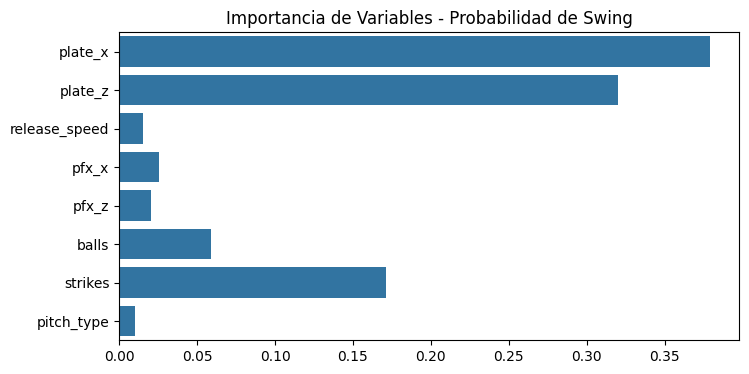

In [33]:
# Definir Target: 1 si hubo Swing, 0 si no
swing_events = ['foul', 'hit_into_play', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip']
df['is_swing'] = df['description'].isin(swing_events).astype(int)

# Features: Aquí la ubicación del lanzamiento (plate_x, plate_z) es CRÍTICA
features_m2 = ['plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 
               'balls', 'strikes', 'pitch_type']

df_model2 = df.dropna(subset=features_m2).copy()

# Codificar pitch_type
le_pitch = LabelEncoder()
df_model2['pitch_type'] = le_pitch.fit_transform(df_model2['pitch_type'].astype(str))

X2 = df_model2[features_m2]
y2 = df_model2['is_swing']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Modelo
rf_swing = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_swing.fit(X_train2, y_train2)

# Evaluación
print(f"Accuracy Probabilidad de Swing: {rf_swing.score(X_test2, y_test2):.4f}")

# Feature Importance
plt.figure(figsize=(8, 4))
sns.barplot(x=rf_swing.feature_importances_, y=features_m2)
plt.title("Importancia de Variables - Probabilidad de Swing")
plt.show()

## 5. Modelo 3: Expected Batting Average (xBA)

**Objetivo:** Para las bolas puestas en juego (`hit_into_play`), predecir si será Hit o Out basándonos ÚNICAMENTE en la velocidad y ángulo de salida.

Esto nos dice qué tan bueno fue el contacto, independientemente de si la defensa atrapó la bola o no.

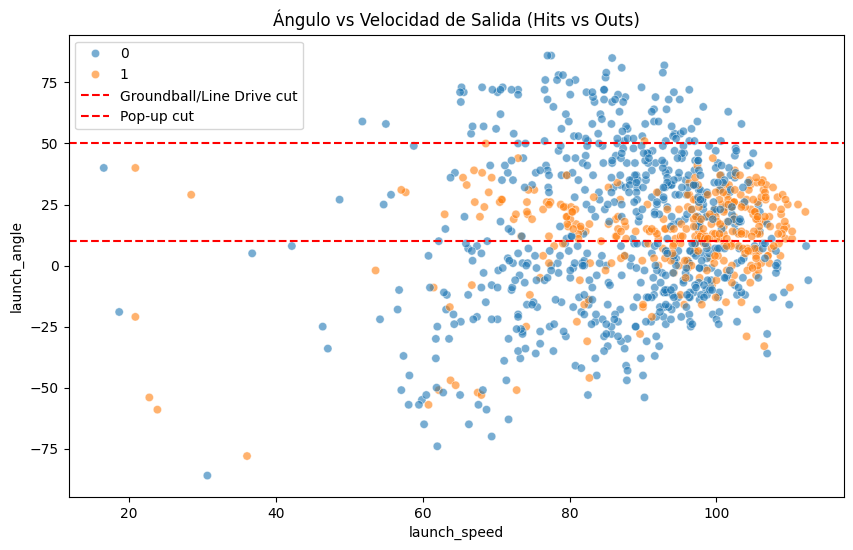

In [34]:
# Filtrar solo bolas en juego con datos de Statcast
df_contact = df[(df['type'] == 'X') & (df['launch_speed'].notna()) & (df['launch_angle'].notna())].copy()

# Definir Target: Es Hit? (Single, Double, Triple, Home Run)
hit_events = ['single', 'double', 'triple', 'home_run']
df_contact['is_hit'] = df_contact['events'].isin(hit_events).astype(int)

features_m3 = ['launch_speed', 'launch_angle']

X3 = df_contact[features_m3]
y3 = df_contact['is_hit']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Modelo
rf_xba = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)
rf_xba.fit(X_train3, y_train3)

# Visualización de la Zona de Hits
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_contact.sample(1000), x='launch_speed', y='launch_angle', hue='is_hit', alpha=0.6)
plt.title("Ángulo vs Velocidad de Salida (Hits vs Outs)")
plt.axhline(y=10, color='r', linestyle='--', label='Groundball/Line Drive cut')
plt.axhline(y=50, color='r', linestyle='--', label='Pop-up cut')
plt.legend()
plt.show()